In [1]:
!pip install ipython-autotime
%load_ext autotime

time: 0 ns (started: 2021-02-09 23:41:35 +02:00)


In [2]:
import numpy as np
import pandas as pd
import seaborn as sns
from sklearn.preprocessing import LabelEncoder, StandardScaler
from sklearn.ensemble import RandomForestClassifier, GradientBoostingClassifier
from sklearn.linear_model import LogisticRegression
from sklearn.model_selection import train_test_split, GridSearchCV, cross_val_score
from sklearn.metrics import accuracy_score, confusion_matrix, classification_report, roc_curve
from matplotlib import pyplot as plt

time: 9.73 s (started: 2021-02-09 23:41:35 +02:00)


In [3]:
df = pd.read_csv('../data/suicides.csv')

time: 390 ms (started: 2021-02-09 23:41:45 +02:00)


In [4]:
df['target'] = pd.qcut(df['num_of_suicides'], q=10, labels=['0-1', '2-4', '5-11', '12-25', '26-49', '50-94', '95-190',
                                                              '191-496', '497-22338'], duplicates='drop')
y = df['target']
df.drop(['num_of_suicides', 'target'], axis=1, inplace=True)

time: 47 ms (started: 2021-02-09 23:41:45 +02:00)


In [5]:
cross_valid_scores = []
train_scores = []
test_scores = []

time: 0 ns (started: 2021-02-09 23:41:45 +02:00)


In [6]:
def confusion_matrix_heatmap(test_y, test_pred, class_names):
  matrix = confusion_matrix(test_y, test_pred)
  matrix = matrix.astype('float') / matrix.sum(axis=1)[:, np.newaxis]
  plt.figure(figsize =(12, 8))
  sns.set(font_scale=1.4)
  sns.heatmap(matrix, annot=True, annot_kws={'size': 10}, cmap="Blues", linewidths=0.2)
  tick_marks = np.arange(len(class_names))
  tick_marks2 = tick_marks + 0.25

  plt.xticks(tick_marks2, class_names, size=10)
  plt.yticks(tick_marks2, class_names, size=10)
  plt.xlabel('Predicted label', size=14)
  plt.ylabel('True label', size=14)
  plt.title('Confusion matrix')

time: 0 ns (started: 2021-02-09 23:41:45 +02:00)


In [7]:
def auc_roc_curve_diagram(test_y, prob_pred):
  fpr, tpr, thresh = {}, {}, {}
  n_class = 9
  for i in range(n_class):
    fpr[i], tpr[i], thresh[i] = roc_curve(test_y, prob_pred[:, i], pos_label=i)
  plt.figure(figsize =(12, 8))
  plt.plot(fpr[0], tpr[0], linestyle='--', color='orange', label='[0-1]')
  plt.plot(fpr[3], tpr[3], linestyle='--', color='red', label='[2-4]')
  plt.plot(fpr[6], tpr[6], linestyle='--', color='magenta', label='[5-11]')
  plt.plot(fpr[1], tpr[1], linestyle='--', color='green', label='[12-25]')
  plt.plot(fpr[4], tpr[4], linestyle='--', color='yellow', label='[26-49]')
  plt.plot(fpr[7], tpr[7], linestyle='--', color='olive', label='[50-94]')
  plt.plot(fpr[8], tpr[8], linestyle='--', color='springgreen', label='[95-190]')
  plt.plot(fpr[2], tpr[2], linestyle='--', color='blue', label='[191-496]')
  plt.plot(fpr[5], tpr[5], linestyle='--', color='purple', label='[497-22338]')
  plt.plot([0, 1], [0, 1], 'k-', alpha=0.75)
  plt.title('ROC curve')
  plt.xlabel('False Positive Rate')
  plt.ylabel('True Positive rate')
  plt.legend(loc='best')

time: 0 ns (started: 2021-02-09 23:41:45 +02:00)


# Random forest


Preprocessing steps 

In [8]:
x = df.copy()
to_convert = ['country', 'sex', 'age', 'generation', 'continent']
x[to_convert] = x[to_convert].astype('category')
x[to_convert] = pd.DataFrame(
    (pd.factorize(x[to_convert].values.ravel())[0] + 1).reshape(x[to_convert].shape),
    columns=to_convert)

x_train, x_valid, y_train, y_valid = train_test_split(x, y, train_size=0.8, random_state=42)
x_train, x_test, y_train, y_test = train_test_split(x_train, y_train, train_size=0.875, random_state=42)

le = LabelEncoder()

y_train = le.fit_transform(y_train)
y_test = le.transform(y_test)
y_valid = le.transform(y_valid)

class_mapping = dict(zip(le.classes_, le.transform(le.classes_)))

time: 281 ms (started: 2021-02-09 23:41:45 +02:00)


Random Forest

In [9]:
rf = RandomForestClassifier(n_estimators=800, criterion='entropy', max_depth=16, min_samples_split=5, max_features='auto',
                                random_state=42, n_jobs=-1)
rf.fit(x_train, y_train)

cross_valid_scores.append(( cross_val_score(rf, x_train, y_train, cv=5).mean()))
train_scores.append(rf.score(x_train, y_train))
test_scores.append(rf.score(x_test, y_test))

time: 13min (started: 2021-02-09 23:41:46 +02:00)


In [10]:
pred_test = rf.predict(x_test)
print(classification_report(y_test, pred_test))

              precision    recall  f1-score   support

           0       1.00      0.99      1.00       575
           1       0.92      0.94      0.93       296
           2       0.96      0.92      0.94       304
           3       0.94      0.96      0.95       269
           4       0.92      0.89      0.91       228
           5       0.97      0.97      0.97       257
           6       0.91      0.90      0.91       282
           7       0.92      0.91      0.92       296
           8       0.90      0.94      0.92       275

    accuracy                           0.94      2782
   macro avg       0.94      0.94      0.94      2782
weighted avg       0.94      0.94      0.94      2782

time: 4.75 s (started: 2021-02-09 23:54:47 +02:00)


Text(0.5, 1.0, 'Feature importance')

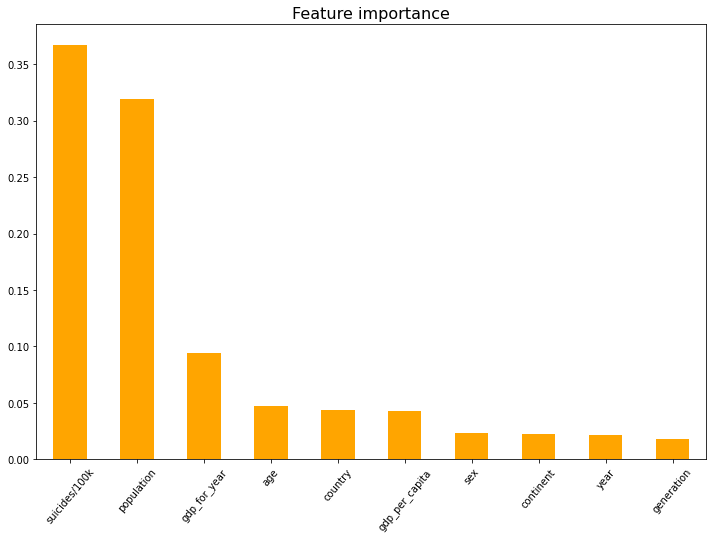

time: 4.92 s (started: 2021-02-09 23:54:52 +02:00)


In [11]:
feature_imp = pd.Series(rf.feature_importances_, index=x_train.columns).sort_values(ascending=False)
feature_imp.plot.bar(color='orange', rot=50, figsize=(12, 8))
plt.title('Feature importance', size=16)

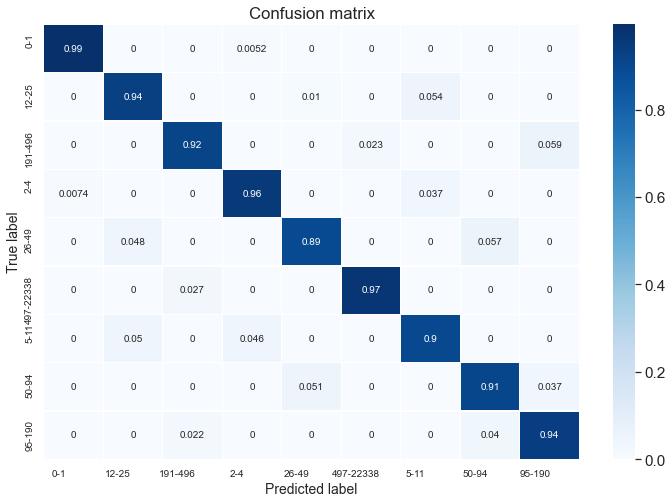

time: 8.12 s (started: 2021-02-09 23:54:57 +02:00)


In [12]:
confusion_matrix_heatmap(y_test, pred_test, class_mapping)

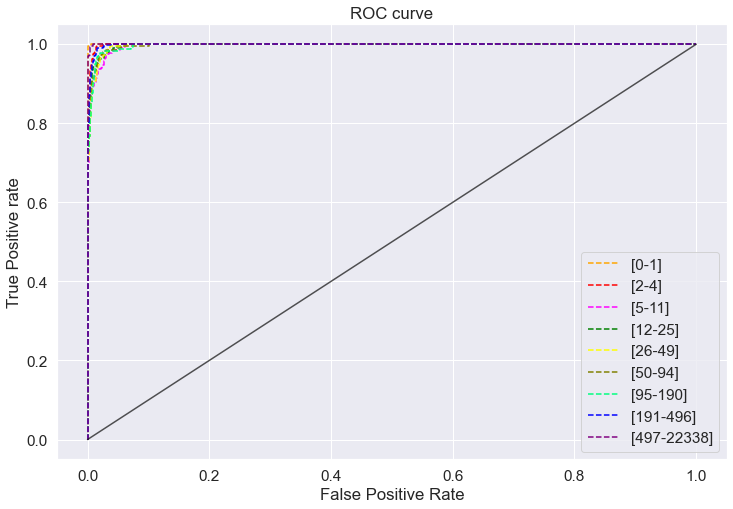

time: 6.47 s (started: 2021-02-09 23:55:05 +02:00)


In [13]:
pred_prob = rf.predict_proba(x_test)
auc_roc_curve_diagram(y_test, pred_prob)

# Logistic Regression and Gradient Boosting

Preprocessing steps
- one hot encoding 
- scaling

In [14]:
data = df.copy() 
data = pd.get_dummies(data, drop_first=True)
x_tr, x_v, y_train, y_valid = train_test_split(data, y, train_size=0.8, random_state=42)
x_tr, x_t, y_train, y_test = train_test_split(x_tr, y_train, train_size=0.875, random_state=42)

x_train = x_tr.copy()
x_test = x_t.copy()
x_valid = x_v.copy()

col = ['year', 'population', 'suicides/100k', 'gdp_for_year', 'gdp_per_capita']

scaler = StandardScaler()

x_train[col] = scaler.fit_transform(x_train[col].values)
x_test[col] = scaler.transform(x_test[col].values)
x_valid[col] = scaler.transform(x_valid[col].values)

le = LabelEncoder()
y_train = le.fit_transform(y_train)
y_test = le.transform(y_test)
y_valid = le.transform(y_valid)

time: 1.27 s (started: 2021-02-09 23:55:11 +02:00)


Logistic Regression 

In [15]:
lg = LogisticRegression(C=10, solver='newton-cg', multi_class='multinomial', max_iter=100,
                             class_weight='balanced',
                             n_jobs=-1, random_state=42)
lg.fit(x_train, y_train)
cross_valid_scores.append((cross_val_score(lg, x_train, y_train, cv=5).mean()))
train_scores.append(lg.score(x_train, y_train))
test_scores.append(lg.score(x_test, y_test))

time: 19min 43s (started: 2021-02-09 23:55:13 +02:00)


In [16]:
pred_test = lg.predict(x_test)
print(classification_report(y_test, pred_test))

              precision    recall  f1-score   support

           0       0.94      0.80      0.86       575
           1       0.50      0.46      0.48       296
           2       0.73      0.75      0.74       304
           3       0.49      0.65      0.56       269
           4       0.32      0.36      0.34       228
           5       0.87      0.88      0.87       257
           6       0.47      0.48      0.47       282
           7       0.54      0.48      0.51       296
           8       0.56      0.59      0.57       275

    accuracy                           0.63      2782
   macro avg       0.60      0.61      0.60      2782
weighted avg       0.64      0.63      0.63      2782

time: 79 ms (started: 2021-02-10 00:14:56 +02:00)


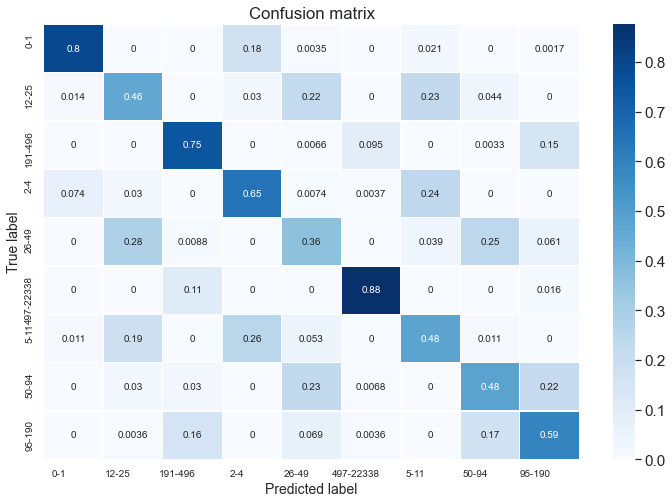

time: 4.06 s (started: 2021-02-10 00:14:57 +02:00)


In [17]:
confusion_matrix_heatmap(y_test, pred_test, class_mapping)

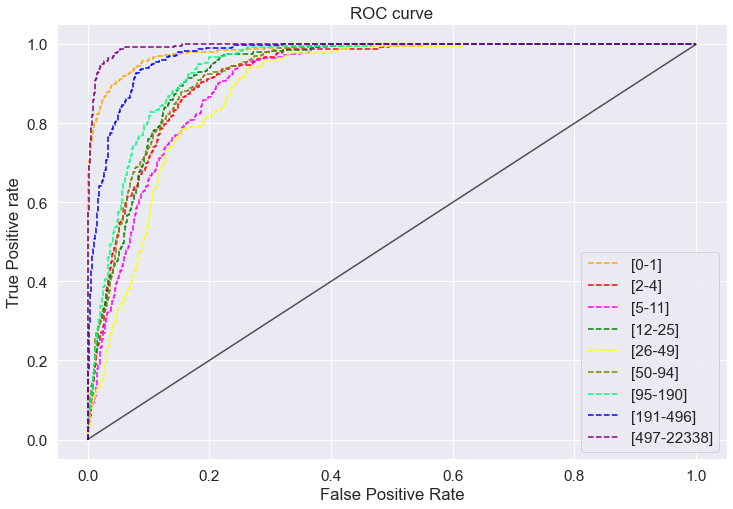

time: 1.05 s (started: 2021-02-10 00:15:01 +02:00)


In [18]:
pred_prob = lg.predict_proba(x_test)
auc_roc_curve_diagram(y_test, pred_prob)

Gradient Boosting 

In [19]:
gb = GradientBoostingClassifier(learning_rate=0.2, max_depth=6, min_samples_leaf=0.1, min_samples_split=0.1, n_estimators=300, random_state=42)
gb.fit(x_train, y_train)
all_scores = cross_val_score(gb, x_train, y_train, cv=5)
cross_valid_scores.append((all_scores.mean()))
train_scores.append(gb.score(x_train, y_train))
test_scores.append(gb.score(x_test, y_test))

time: 55min 30s (started: 2021-02-10 00:15:02 +02:00)


Text(0.5, 1.0, 'Feature importance')

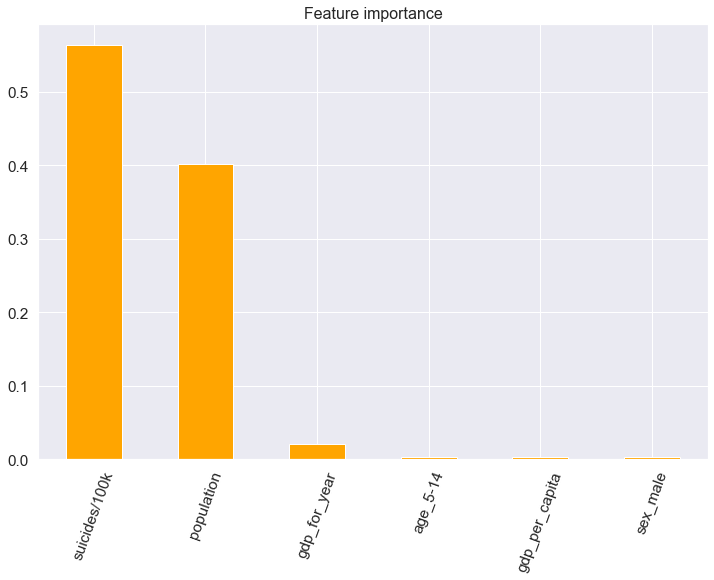

time: 1.69 s (started: 2021-02-10 01:10:33 +02:00)


In [20]:
feature_imp = pd.Series(gb.feature_importances_, index=x_train.columns).sort_values(ascending=False)
feature_imp = feature_imp.iloc[:6].sort_values(ascending=False)
feature_imp.plot.bar(color='orange', rot=70, figsize=(12, 8))
plt.title('Feature importance', size=16)

In [21]:
feature_imp = feature_imp.iloc[6:10].sort_values(ascending=False)
feature_imp

Series([], dtype: float64)

time: 15 ms (started: 2021-02-10 01:10:34 +02:00)


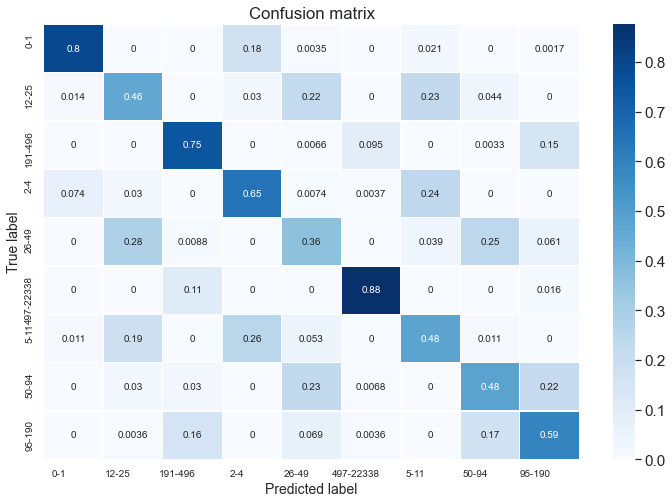

time: 6.27 s (started: 2021-02-10 01:10:34 +02:00)


In [22]:
confusion_matrix_heatmap(y_test, pred_test, class_mapping)

In [23]:
print(classification_report(y_test, pred_test))

              precision    recall  f1-score   support

           0       0.94      0.80      0.86       575
           1       0.50      0.46      0.48       296
           2       0.73      0.75      0.74       304
           3       0.49      0.65      0.56       269
           4       0.32      0.36      0.34       228
           5       0.87      0.88      0.87       257
           6       0.47      0.48      0.47       282
           7       0.54      0.48      0.51       296
           8       0.56      0.59      0.57       275

    accuracy                           0.63      2782
   macro avg       0.60      0.61      0.60      2782
weighted avg       0.64      0.63      0.63      2782

time: 47 ms (started: 2021-02-10 01:10:41 +02:00)


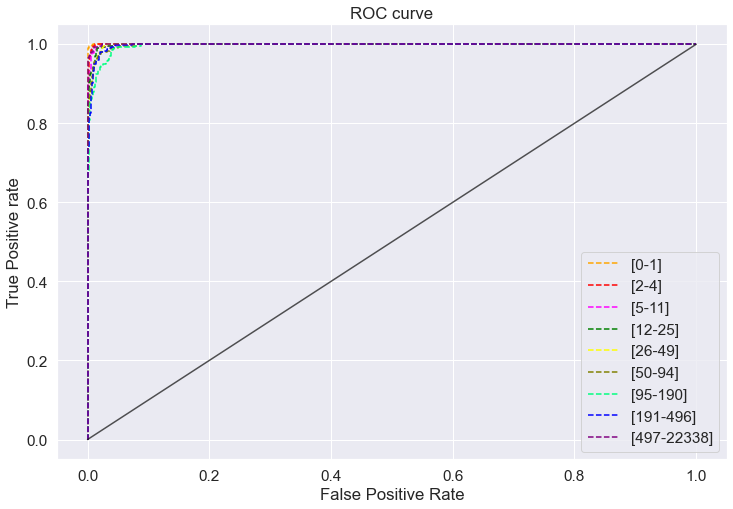

time: 3.28 s (started: 2021-02-10 01:10:41 +02:00)


In [24]:
pred_prob = gb.predict_proba(x_test)
auc_roc_curve_diagram(y_test, pred_prob)

Comparison of the three classifiers

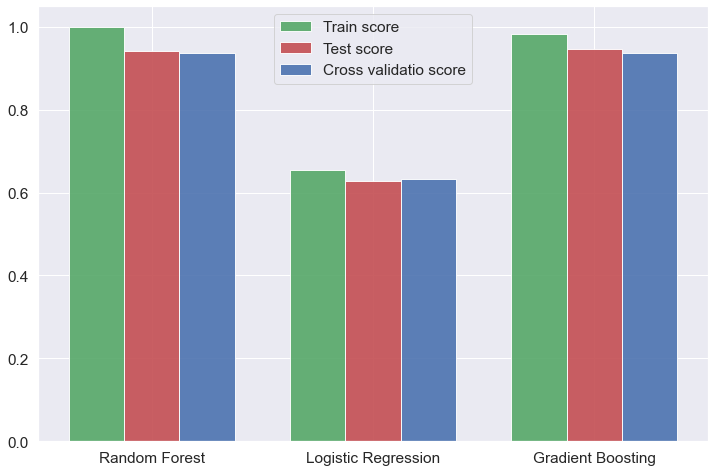

time: 1.12 s (started: 2021-02-10 01:10:44 +02:00)


In [25]:
fig = plt.subplots(figsize =(12, 8)) 
bar_width = 0.25
opacity = 0.9
classifier = ['Random Forest', 'Logistic Regression', 'Gradient Boosting']
br1 = np.arange(len(classifier)) 
br2 = [x + bar_width for x in br1] 
br3 = [x + bar_width for x in br2] 

rects1 = plt.bar(br1, train_scores, bar_width,
alpha=opacity,
color='g',
label='Train score')

rects2 = plt.bar(br2, test_scores, bar_width,
alpha=opacity,
color='r',
label='Test score')

rects2 = plt.bar(br3, cross_valid_scores, bar_width,
alpha=opacity,
color='b',
label='Cross validatio score')
plt.legend()
plt.xticks([r + bar_width for r in range(len(classifier))], 
           classifier) 
plt.show() 

time: 1.14 s (started: 2021-02-10 01:10:44 +02:00)
